In [1]:
from IPython import display
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import omegaconf
from gymnasium import spaces
import gymnasium as gym


import mbrl.models as models
from mbrl.models import Ensemble
import mbrl.planning as planning
import mbrl.util.common as common_util
import mbrl.util as util
from pyoperon.sklearn import SymbolicRegressor


%load_ext autoreload
%autoreload 2

mpl.rcParams.update({"font.size": 16})

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
def term_fn(a, next_obs):
    #threshold = 10
    #not_done = (next_obs > -threshold)* (next_obs < threshold)
    #done = ~not_done
    #done = done[:, None]
    return False

def reward_fn(a, next_obs):
    return torch.cos(2 * torch.pi * next_obs) * torch.exp(torch.abs(next_obs) / 3)

In [536]:
class Simple1DMDP(gym.Env):
    def __init__(self):
        super(Simple1DMDP, self).__init__()
        
        # define the action space
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        
        # define the observation space: continuous single dimension for position
        self.observation_space = spaces.Box(low=-10, high=10, shape=(1,), dtype=np.float32)
        # Initialize state and episode length
        self.state = 0.0
        self.episode_length = 10
        self.current_step = 0

    def reset(self, seed=None):
        # reset the state to 0 and the step counter
        self.state = 0.0
        self.current_step = 0
        return torch.FloatTensor([self.state]), {}

    def step(self, action):  
        # update state based on action
        self.state += action
        # clip in the case we go outside of [-10,10]
        # set truncated parameter
        truncated = np.abs(self.state) > 10
        self.state = np.clip(self.state, -10.,10.)
        
        # calculate reward
        #reward = torch.cos(2 * torch.pi * self.state) * torch.exp(torch.abs(self.state) / 3)
        reward = reward_fn(torch.from_numpy(action), torch.from_numpy(self.state))
        # increment step counter
        self.current_step += 1
        # check if episode is terminated
        terminated = self.current_step >= self.episode_length
        
        # set placeholder for info
        info = {}
        return torch.FloatTensor([self.state]).flatten(), reward, terminated, truncated, info

    def render(self, mode='human'):
        # simple print rendering
        print(f"Step: {self.current_step}, State: {self.state}")

In [537]:
class SymbolicModel(Ensemble):
    def __init__(self, symbols, population_size, generations, max_length, max_depth, in_size, out_size,
                num_members, device, propagation_method, deterministic):
        super().__init__(num_members, device, propagation_method, deterministic)
        self.in_size = in_size
        self.out_size = out_size
        self.reg = SymbolicRegressor(population_size = population_size,
                                     allowed_symbols=symbols,
                                     optimizer_iterations=10,
                                     generations = generations,
                                     n_threads=32,
                                     max_length = max_length,
                                     max_depth=max_depth,
                                     epsilon=0)
    def forward(self, x, rng, propagation_indices):
        next_obs= x[:,0] + x[:,1]
        reward = self.reg.predict(x)
        preds = np.vstack((next_obs, reward)).T
        return torch.from_numpy(preds), None
    
    def loss(self, model_in, target):
        return self.reg.score(model_in, target)
    
    def eval_score(self, model_in, target):
        return self.reg.score(model_in, target)
    
    def sample_propagation_indices(
        self, batch_size: int, _rng: torch.Generator) -> torch.Tensor:
        model_len = num_members
        if batch_size % model_len != 0:
            raise ValueError(
                "To use SymbolicModel's ensemble propagation, the batch size must "
                "be a multiple of the number of models in the ensemble."
            )
        # rng causes segmentation fault, see https://github.com/pytorch/pytorch/issues/44714
        return torch.randperm(batch_size, device=self.device)

In [539]:
# Register the custom environment
gym.envs.registration.register(
    id='Simple1DMDP-v0',
    entry_point=Simple1DMDP
)


env = gym.make('Simple1DMDP-v0')

In [541]:
seed = 0
env.reset()
rng = np.random.default_rng(seed=seed)
generator = torch.Generator(device=device)
generator.manual_seed(seed)
obs_shape = env.observation_space.shape
act_shape = env.action_space.shape

In [542]:
# Neural Network

trial_length = 500
num_trials = 10
ensemble_size = 7

# Everything with "???" indicates an option with a missing value.
# Our utility functions will fill in these details using the 
# environment information
cfg_dict = {
    # dynamics model configuration
    "dynamics_model": {
        "_target_": "mbrl.models.GaussianMLP",
        "device": device,
        "num_layers": 4,
        "ensemble_size": ensemble_size,
        "hid_size": 200,
        "in_size": "???",
        "out_size": "???",
        "deterministic": True,
        "propagation_method": "fixed_model",
        # can also configure activation function for GaussianMLP
        "activation_fn_cfg": {
            "_target_": "torch.nn.SiLU"}
    },
    # options for training the dynamics model
    "algorithm": {
        "learned_rewards": True,
        "target_is_delta": True,
        "normalize": True,
    },
    # these are experiment specific options
    "overrides": {
        "trial_length": trial_length,
        "num_steps": num_trials * trial_length,
        "model_batch_size": 1,
        "validation_ratio": 0.05
    }
}
cfg = omegaconf.OmegaConf.create(cfg_dict)

In [543]:
# Symbolic Regression

trial_length = 500
num_trials = 10
ensemble_size = 1

device = "cpu"

# Everything with "???" indicates an option with a missing value.
# Our utility functions will fill in these details using the 
# environment information
cfg_dict = {
    # dynamics model configuration
    "dynamics_model": {
        "_target_": "__main__.SymbolicModel",
        "symbols": "add,sub,mul,div,constant,variable,sin,exp,abs",
        "population_size": 5000,
        "generations": 10000,
        "max_length": 30,
        "max_depth": 10,
        "in_size": "???",
        "out_size": "???",
        "device": device,
        "deterministic": True,
        "propagation_method": None,
        "num_members": ensemble_size
    },
    # options for training the dynamics model
    "algorithm": {
        "learned_rewards": True,
        "target_is_delta": True,
        "normalize": True,
    },
    # these are experiment specific options
    "overrides": {
        "trial_length": trial_length,
        "num_steps": num_trials * trial_length,
        "model_batch_size": 1,
        "validation_ratio": 0.05
    }
}
cfg = omegaconf.OmegaConf.create(cfg_dict)

In [544]:
# Create a 1-D dynamics model for this environment
dynamics_model = common_util.create_one_dim_tr_model(cfg, obs_shape, act_shape)
dynamics_model.set_elite([0])

# Create a gym-like environment to encapsulate the model
model_env = models.ModelEnv(env, dynamics_model, term_fn, reward_fn, generator=generator)

In [549]:
replay_buffer = common_util.create_replay_buffer(cfg, obs_shape, act_shape, rng=rng)

In [550]:
common_util.rollout_agent_trajectories(
    env,
    trial_length, # initial exploration steps
    planning.RandomAgent(env),
    {}, # keyword arguments to pass to agent.act()
    replay_buffer=replay_buffer,
    trial_length=trial_length
)

print("# samples stored", replay_buffer.num_stored)

# samples stored 500


In [551]:
agent_cfg = omegaconf.OmegaConf.create({
    # this class evaluates many trajectories and picks the best one
    "_target_": "mbrl.planning.TrajectoryOptimizerAgent",
    "planning_horizon": 3,
    "replan_freq": 1,
    "verbose": False,
    "action_lb": "???",
    "action_ub": "???",
    # this is the optimizer to generate and choose a trajectory
    "optimizer_cfg": {
        "_target_": "mbrl.planning.CEMOptimizer",
        "num_iterations": 10,
        "elite_ratio": 0.1,
        "population_size": 999,
        "alpha": 0.1,
        "device": device,
        "lower_bound": "???",
        "upper_bound": "???",
        "return_mean_elites": True,
        "clipped_normal": False
    }
})

agent = planning.create_trajectory_optim_agent_for_model(
    model_env,
    agent_cfg,
    num_particles=20
)

In [552]:
train_losses = []
val_scores = []

def train_callback(_model, _total_calls, _epoch, tr_loss, val_score, _best_val):
    train_losses.append(tr_loss)
    val_scores.append(val_score.mean().item())

In [553]:
class SymbolicModelTrainer:
    def __init__(self, dynamics_model: SymbolicModel):
        self.dynamics_model = dynamics_model
    
    def train(self, dataset_train, dataset_val):
        X_train = np.hstack((dataset_train.transitions.obs, dataset_train.transitions.act))
        X_val = np.hstack((dataset_val.transitions.obs, dataset_val.transitions.act))
        y_train = dataset_train.transitions.rewards
        y_val = dataset_val.transitions.rewards
        # reshuffling
        p_train = np.random.permutation(len(X_train))
        reg = self.dynamics_model.model.reg
        reg.fit(X_train[p_train], y_train[p_train])
        print(reg.get_model_string(reg.model_))
        return reg.score(X_train, y_train), reg.score(X_val, y_val)

In [554]:
# Create a trainer for the model
#model_trainer = models.ModelTrainer(dynamics_model, optim_lr=7.5e-4, weight_decay=3e-5)
model_trainer = SymbolicModelTrainer(dynamics_model)
# Main PETS loop
all_rewards = [0]
for trial in range(num_trials):
    print(trial)
    obs, _ = env.reset()    
    agent.reset()
    
    terminated = False
    total_reward = 0.0
    steps_trial = 0
    while not terminated:
        # --------------- Model Training -----------------
        if steps_trial == 0:
            dynamics_model.update_normalizer(replay_buffer.get_all())  # update normalizer stats
                        
            dataset_train, dataset_val = common_util.get_basic_buffer_iterators(
                replay_buffer,
                batch_size=cfg.overrides.model_batch_size,
                val_ratio=cfg.overrides.validation_ratio,
                ensemble_size=ensemble_size,
                shuffle_each_epoch=True,
                bootstrap_permutes=False,  # build bootstrap dataset using sampling with replacement
            )
            
            print(dataset_train.num_stored, dataset_val.num_stored)
            
            # process and standardize the data
            X_train = np.hstack((dataset_train.transitions.obs, dataset_train.transitions.act))
            X_val = np.hstack((dataset_val.transitions.obs, dataset_val.transitions.act))
            y_train = dataset_train.transitions.rewards
            y_val = dataset_val.transitions.rewards
            #mean_train = np.mean(X_train, axis = 0)
            #std_train = np.std(X_train, axis = 0)
            #X_train_norm = X_train - np.
            
            
            
                
            #model_trainer.train(
            #    dataset_train, 
            #    dataset_val=dataset_val, 
            #    num_epochs=2000, 
            #    patience=25, 
            #    callback=train_callback,
            #    silent=True)
            train_r2, val_r2 = model_trainer.train(dataset_train, dataset_val)
            print(train_r2, val_r2)
            
            

        # --- Doing env step using the agent and adding to model dataset ---
        next_obs, reward, terminated, truncated, _ = common_util.step_env_and_add_to_buffer(
            env, obs, agent, {}, replay_buffer)            
        
        print(next_obs, reward, terminated, truncated)
        
        obs = next_obs
        total_reward += reward
        steps_trial += 1
        
        if steps_trial == trial_length:
            break
    
    all_rewards.append(total_reward)

0
475 25
((-0.006) + (1.000 * (((sin((((0.868 * X1) + (0.881 * X2)) - 1.575)) / 1.297) - (-1.859)) * sin(((((0.653 * X1) + (0.653 * X2)) - 0.490) / 0.104)))))
0.9992892742156982 0.9994442462921143
tensor([0.9436]) tensor([1.2845]) False [False]
tensor([1.8773]) tensor([1.3406]) False [False]
tensor([2.8047]) tensor([0.8583]) False [False]
tensor([3.7645]) tensor([0.3201]) False [False]
tensor([4.6976]) tensor([-1.5468]) False [False]
tensor([5.6567]) tensor([-3.6457]) False [False]
tensor([6.5968]) tensor([-7.3980]) False [False]
tensor([7.5598]) tensor([-11.5601]) False [False]
tensor([8.5060]) tensor([-17.0240]) False [False]
tensor([9.4613]) tensor([-22.7364]) True [False]
1
485 25
(0.002 + (1.001 * ((sin((6.183 * X1)) - ((abs((-5.544)) + (2.539 * X1)) * (abs((1.698 + (1.738 * X1))) * ((0.011 * X1) - 0.024)))) / (0.014 / (0.011 * X2)))))
0.6888334155082703 -0.09916496276855469
tensor([0.8383]) tensor([0.6964]) False [False]
tensor([1.7089]) tensor([-0.4513]) False [False]
tensor([2.

In [555]:
num_data = 999
data = torch.zeros((num_data,2))
data[:,0] = torch.linspace(-10,10, num_data)

In [556]:
print(dynamics_model.model.reg.get_model_string(dynamics_model.model.reg.model_))

((-0.064) + (1.001 * ((abs((((-0.006) * X2) + (0.006 * X1))) * ((((1.614 * X1) - 1.233) * (((25.492 - ((-1.767) * X1)) + (0.150 * X1)) + ((-9.512) * X2))) + (exp((-9.451)) - ((-131.698) * X2)))) * sin(((((-4.582) * X1) - 59.753) - (1.844 * X1))))))


In [557]:
reward = dynamics_model.model.reg.predict(data)

In [158]:
#with torch.no_grad():
#    reward = dynamics_model.model(data.to("cuda"), propagation_indices=np.arange(num_data))[0][:,1]

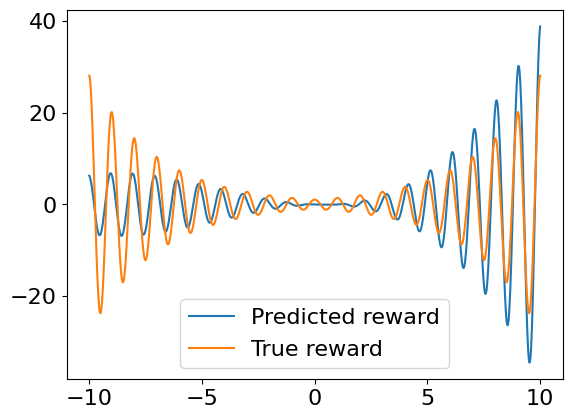

In [558]:
#plt.plot(data[:,0], reward.to("cpu"))
plt.plot(data[:,0], reward, label="Predicted reward")
plt.plot(data[:,0], reward_fn(data[:,1], data[:,0]), label="True reward")
plt.legend()
plt.show()